In [1]:
# Descarga de archivos de ProfNER
!wget https://zenodo.org/record/4563995/files/profner.zip?download=1
# Si el unzip no funciona, revisar cual es el nombre de descarga del archivo
!unzip  profner.zip?download=1

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: profner/subtask-1/test-background-txt-files/1243953060050763778.txt  
  inflating: profner/subtask-1/test-background-txt-files/1243988693947486209.txt  
  inflating: profner/subtask-1/test-background-txt-files/1244173600753618945.txt  
  inflating: profner/subtask-1/test-background-txt-files/1244319340062822405.txt  
  inflating: profner/subtask-1/test-background-txt-files/1247000104193712129.txt  
  inflating: profner/subtask-1/test-background-txt-files/1247263989249212416.txt  
  inflating: profner/subtask-1/test-background-txt-files/1247465550931988482.txt  
  inflating: profner/subtask-1/test-background-txt-files/1249075777544556545.txt  
  inflating: profner/subtask-1/test-background-txt-files/1249253729720766466.txt  
  inflating: profner/subtask-1/test-background-txt-files/1249964965546668034.txt  
  inflating: profner/subtask-1/test-background-txt-files/1249980196838682624.txt  
  inflating: profner/subta

Funciones de carga y preparación de datos

In [2]:
import sys
import os
import pandas as pd
def get_tweet_content(list_paths):
  """
    Función para guardar en un diccionario el contenido de archivos txt 
    que se introduce en su entrada. 
    Devuelve un diccionario en el que las claves son el id del tweet, y
    el valor el texto del tweet.
  """
  output_dict = dict()
  for i in list_paths:
    tweet_id = i.split("/")[-1].split(".txt")[0]
    with open(i) as f:
      output_dict[int(tweet_id)] = f.read()
  
  return output_dict

def get_profner_data(profner_path_data):
    # Obtenemos el path a los txt de los tweets.
    path_to_txt = profner_path_data+"subtask-1/train-valid-txt-files/"
    tweets_train_files = [path_to_txt+"train/"+i for i in os.listdir(path_to_txt+"train/")]
    tweets_valid_files = [path_to_txt+"valid/"+i for i in os.listdir(path_to_txt+"valid/")]
    # Obtenemos diccionarios en los que el key es el tweet_id y el value el texto del tweet.
    train_txt_content = get_tweet_content(tweets_train_files)
    valid_txt_content = get_tweet_content(tweets_valid_files)

    # Cargamos dos dataframes con los tweet_id y la categoría de los tweets
    path_to_labeled = profner_path_data+"subtask-1/"
    train_tweets = pd.read_csv(path_to_labeled+"train.tsv",sep="\t")
    valid_tweets = pd.read_csv(path_to_labeled+"valid.tsv",sep="\t")

    # Introducimos a los df el campo de texto mapeando los diccionarios con tweet_id
    train_tweets["tweet_text"] = train_tweets['tweet_id'].map(train_txt_content)
    train_tweets["set"] = "train"
    valid_tweets["tweet_text"] = valid_tweets['tweet_id'].map(valid_txt_content)
    valid_tweets["set"] = "valid"

    # Concatenamos el resultado
    output_df = pd.concat([train_tweets,valid_tweets],axis=0)
    # Eliminamos retorno de carro
    output_df["tweet_text"] = output_df.tweet_text.apply(lambda x: x.replace('\n', ' '))
    return output_df[["tweet_id","tweet_text","label","set"]].reset_index(drop=True)

# Ejercicio


En este ejercicio se trabajará con un conjunto de datos reales publicados para la shared-task [ProfNER](https://temu.bsc.es/smm4h-spanish/), celebrada en el año 2021. Específicamente, se utilizarán los datos textuales de la subtarea 1, centrada en la clasificación de textos. Este conjunto de datos son tweets en español que tienen asignada una etiqueta numérica, que representa la presencia (valor 1) o no (valor 0) de menciones de profesiones en el tweet. Por si fuera de tu interés, el proceso de obtención, selección y anotación de datos está descrita en [este enlace.](https://temu.bsc.es/smm4h-spanish/?p=4003).

Para el ejercicio debéis entrenar diferentes modelos de clasificación que permitan clasificar correctamente los tweets. Para ello será necesario crear y utilizar funciones de preprocesado de datos similares a las vistas en clase, aplicar estrategias de vectorización de trextos como TF-IDF o embeddings, y entrenar/evaluar modelos de clasificación. Para que os sirva de orientación, los criterios de evaluación del ejercicio serán los siguientes:

-	**Análisis exploratorio, pre-procesado y normalización de los datos (30%)**:
        -	El ejercicio deberá contener un análisis exploratorio de los datos como número de documentos, gráficas de distribución de longitudes y/o wordclouds, entre otros análisis que se os pudieran ocurrir. Vuestros ejercicios deberán incorporar al menos los análisis exploratorios vistos en clase.

    -	También tendréis que tener funciones para normalizar textos que permitan eliminar palabras vacías, quitar símbolos de puntuación y lematizar o hacer stemming.  

-	**Vectorización de textos (40%)**

    En clase hemos visto diferentes estrategias de vectorización como TF-IDF y Word Embeddings. También hemos visto como incorporar características adicionales utilizando el sentimiento de los documentos. Para este ejercicio sois libres de utilizar la estrategia de vectorización que queráis, pero:
  -	Si decidís utilizar TF-IDF será necesarios que incorporéis a modelo características adicionales de sentimiento utilizando recursos adicionales (como por ejemplo la librería TextBlob). 
  -	Si optáis por representar el texto mediante embeddings, dado que en clase no se profundizado sobre el tema no será necesario incorporar esas características adicionales. Si decidís esta segunda opción, podéis utilizar los embeddings en español que vimos en clase

-	**Entrenamiento y validación del sistema (30%)**
  -	En el proceso de entrenamiento del modelo tendréis que testear al menos 3 modelos de clasificación. El procedimiento debe ser similar al visto en clase, en el que primero estimábamos el rendimiento de varios algoritmos de forma general, para posteriormente seleccionar el mejor para ajustar los hiperparámetros.


## 0. Imports


In [3]:
import nltk
import sys  
import os
!{sys.executable} -m pip install contractions
!pip install spacy==3.2.1
!python -m spacy download es_core_news_sm
nltk.download('punkt')
nltk.download('stopwords')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import string 
import re 
import inflect
from textblob import TextBlob
from nltk.tokenize import TweetTokenizer
import contractions 
from tqdm.autonotebook import tqdm
tqdm.pandas()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 5.4 MB/s 
     |████████████████████████████████| 287 kB 36.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.0 MB 5.3 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: spacy
    Found existing installation: spacy 3.3.1
    Uninstalling spacy-3.3.1:
      Successfully uninstalled spacy-3.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.3.0 requires spacy<3.4.0,>=3.3.0.dev0, but you have spacy 3.2.1 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.0 MB 5.1 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## 1. Obtención del corpus
Para la obtención de los datos teneis disponible la función `get_profner_data()`. Esta función prepara los datos del ejercicio en formato Pandas dataframe para que podais realizarlo.

In [4]:
profner_path = "./profner/"
datos_ejercicio = get_profner_data(profner_path)

In [5]:
datos_ejercicio.head(4)

,tweet_id,tweet_text,label,set
0,1256007275807997953,CHINA: libera una pandemia EE.UU: libera OVNIS...,0,train
1,1257909427677601792,San Francisco (EEUU) hace 100 años tras vivir ...,0,train
2,1281580572415066112,Porfi poneos la mascarilla o tendremos 28 nuev...,0,train
3,1271348112733470720,El nuevo „covid normas y reglas recibimiento“ ...,0,train


## 2. Análisis exploratorio

* **Número de documentos y columnas:**

Comenzamos mostrando el número de documentos, o lo que es lo mismo, el número de filas del data frame:




In [6]:
print("Tenemos un conjunto de {} documentos".format(len(datos_ejercicio)))
print("El dataframe tiene {} columnas".format(datos_ejercicio.shape[1]))

Tenemos un conjunto de 8000 documentos
El dataframe tiene 4 columnas


* **Número de documentos duplicados:**

Comprobamos si hay tweets duplicados y en tal caso los eliminamos.


In [7]:
# metodo duplicated con subset=["title"]
print("Existen {} tweets duplicados".format(np.sum(datos_ejercicio.duplicated(subset="tweet_text")))) 


Existen 0 tweets duplicados


* **Número de documentos por cada clase:**

Contamos el número de elementos de cada clase.

In [8]:
# Número de elementos de cada clase:
datos_ejercicio.groupby(['label']).count()

,tweet_id,tweet_text,set
label,,,
0,6130,6130,6130
1,1870,1870,1870


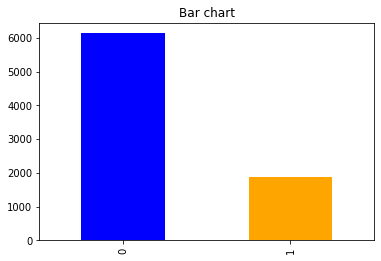

In [9]:
ax, fig = plt.subplots()
etiquetas = datos_ejercicio.label.value_counts()
etiquetas.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.show()

Observamos que nuestro dataset no está balanceado, tenemos más tweets de clase 0, es decir sin mención a profesiones, que de clase 1.

Para compensar este desbalanceo se puede reducir los datos de clase 0, pero de esta manera se puede perder información del dataset. Otra forma de compensar esto sería con una penalización en el modelo de clasificación.

* **Distribución de la longitud de los tweet en caracteres:**



In [9]:
datos_ejercicio["char_len"] = datos_ejercicio["tweet_text"].apply(lambda x:len(x))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


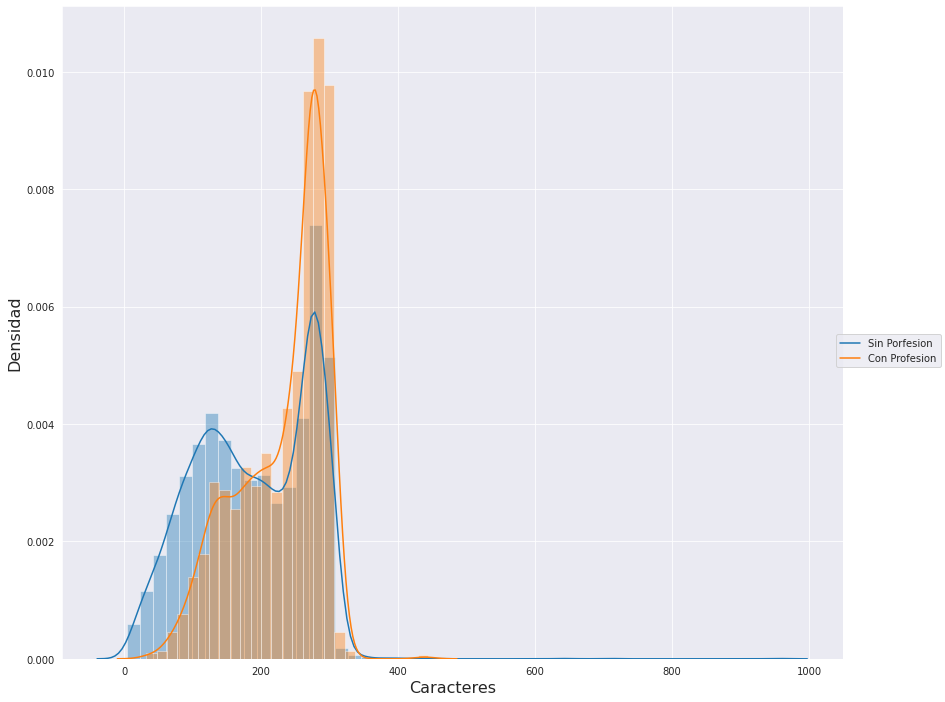

In [10]:
# Importamos las librerías matplotlib y seaborn:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")
# añadimos series para cada categoría (eligiendo la seríe de char_len
plt1 = sns.distplot(datos_ejercicio[datos_ejercicio.label==0].char_len, hist=True, label="Sin Porfesion")
plt2 = sns.distplot(datos_ejercicio[datos_ejercicio.label==1].char_len, hist=True, label="Con Profesion")
fig.legend(labels=['Sin Porfesion','Con Profesion'], loc = 5)


# Definimos el título de los ejes:
plt.xlabel('Caracteres', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

# Finalmente mostramos el gráfico:
plt.show()


La longitud de los tweets no presenta diferencia entre ambas clases.

## 3. Preprocesado y Normalización



*   **Normalización**
   - Eliminar espacios extra.
   - Transformar a minúsculas.
   - Tokenizar.
   - Reemplazar contractions.
   - Lematizar tokens.
   - Eliminar stopwords.
   - Eliminar sígnos de puntuación.



In [11]:
# Eliminar espacios
def eliminar_espacios(text): 
    return  " ".join(text.split()) 

# To lower
def texto_to_lower(text):
  return text.lower()

# Tokenizador
def tokenize(texto):
  tweet_tokenizer = TweetTokenizer()
  tokens_list = tweet_tokenizer.tokenize(texto)
  return tokens_list

# Reemplazar contractions usando la librería "contractions" https://github.com/kootenpv/contractions
def replace_contraction(text):
    expanded_words = []
    for t in text.split():
        expanded_words.append(contractions.fix(t))
    expanded_text = ' '.join(expanded_words) 
    return expanded_text

# Quitar stop words
from nltk.corpus import stopwords
def quitar_stopwords(tokens):
    stop_words = set(stopwords.words('spanish')) 
    filtered_sentence = [w for w in tokens if not w in stop_words]
    return filtered_sentence


# Eliminar signos de puntuación (nos quedamos sólo lo alfanumérico en este caso)
def quitar_puntuacion(tokens):
    words=[word for word in tokens if word.isalnum()]
    return words

#Reemplazar numeros
def replace_numbers(words):
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

# Stemming

import string
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer(language="spanish") 
def stem(tokens):
    tokens = [ stemmer.stem(token) for token in tokens]
    return tokens


In [12]:
def data_preparation(texto):
    texto = eliminar_espacios(texto)
    texto = texto_to_lower(texto)
    texto = replace_contraction(texto)
    texto = tokenize(texto)
    texto = replace_numbers(texto)
    texto = quitar_stopwords(texto)
    texto = quitar_puntuacion(texto)
    texto = stem(texto)
    return texto

In [13]:
# Se aplica la función de limpieza y tokenización a cada tweet

datos_ejercicio['texto_normalizado'] = datos_ejercicio['tweet_text'].apply(lambda x: data_preparation(x))
datos_ejercicio[['tweet_text', 'texto_normalizado']].head()

,tweet_text,texto_normalizado
0,CHINA: libera una pandemia EE.UU: libera OVNIS...,"[chin, liber, pandemi, liber, ovnis, argentin,..."
1,San Francisco (EEUU) hace 100 años tras vivir ...,"[san, francisc, eeuu, hac, años, tras, viv, pa..."
2,Porfi poneos la mascarilla o tendremos 28 nuev...,"[porfi, pone, mascarill, nuev, cancion, artist..."
3,El nuevo „covid normas y reglas recibimiento“ ...,"[nuev, cov, norm, regl, recib, comerci, minor,..."
4,Si el confinamiento ha dejado algo tocada tu e...,"[si, confin, dej, toc, estabil, mental, siempr..."




*   **Caracteristicas de Sentimiento**

Tras un intento de utilizar TextBlob y obtener complicaciones por estar los tweets en español, procedemos a aplicar el recurso propuesto en clase: **Spanish Emotion Lexicon (SEL)**

Descargamos los datos de Spanish Emotion Lexicon de la web de Grigori Sidorov

In [14]:
url_path = "https://www.cic.ipn.mx/~sidorov/SEL.txt"
sel_lexicon = pd.read_csv(url_path,sep="\t", encoding="latin-1")

In [15]:
dicc_mapping = {"Alegría":"positive",
                "Sorpresa":"positive",
                "Tristeza":"negative",
                "Enojo":"negative",
                "Miedo":"negative",
                "Repulsión":"negative"}
                
sel_lexicon["Categoría"] = sel_lexicon["Categoría"].map(dicc_mapping)

In [16]:
positive_words = dict(zip(sel_lexicon[sel_lexicon["Categoría"]=="positive"].Palabra, sel_lexicon[sel_lexicon["Categoría"]=="positive"][' PFA']))
negative_words = dict(zip(sel_lexicon[sel_lexicon["Categoría"]=="negative"].Palabra, sel_lexicon[sel_lexicon["Categoría"]=="negative"][' PFA']))

In [17]:
def calculate_sentiment(frase, positive_words, negative_words):
  """
  Función para calcular el score de sentimiento de una frase

  Args:
    frase [str]: Frase pre-preprocesada en español. Debe venir lematizada.
    positive_words [dict]: Diccionario de palabras positivas extraidas de SEL
    negative_words [dict]: Diccionario de palabras negativas extraídas de SEL

  Out:
    Sentiment score  
  """
  score = 0
  for i in frase.split():
    if i in positive_words:
      score = score + float(positive_words[i])
    elif i in negative_words:
      score = score - float(negative_words[i])
    else:
      score = score + 0
  
  return score


In [18]:
datos_ejercicio['caracteristicas_sentimiento'] = datos_ejercicio['tweet_text'].apply(calculate_sentiment,args=(positive_words, negative_words))

In [19]:
datos_ejercicio.head()

,tweet_id,tweet_text,label,set,char_len,texto_normalizado,caracteristicas_sentimiento
0,1256007275807997953,CHINA: libera una pandemia EE.UU: libera OVNIS...,0,train,87,"[chin, liber, pandemi, liber, ovnis, argentin,...",0.00
1,1257909427677601792,San Francisco (EEUU) hace 100 años tras vivir ...,0,train,90,"[san, francisc, eeuu, hac, años, tras, viv, pa...",0.63
2,1281580572415066112,Porfi poneos la mascarilla o tendremos 28 nuev...,0,train,95,"[porfi, pone, mascarill, nuev, cancion, artist...",0.00
3,1271348112733470720,El nuevo „covid normas y reglas recibimiento“ ...,0,train,225,"[nuev, cov, norm, regl, recib, comerci, minor,...",0.00
4,1270421287148695556,Si el confinamiento ha dejado algo tocada tu e...,0,train,138,"[si, confin, dej, toc, estabil, mental, siempr...",0.00


Generamos una frase de gada una de las listas de tokens antes de introducirlo a TFIDF

In [20]:
datos_ejercicio["clean_text"] = datos_ejercicio["texto_normalizado"].progress_apply(lambda x: " ".join(x))

  0%|          | 0/8000 [00:00<?, ?it/s]

## 4. Vectorización

In [22]:
vectorizador = TfidfVectorizer(ngram_range=(1,3),
                               min_df=0.005,
                               lowercase=False)
                               

In [23]:
vector_data = vectorizador.fit_transform(datos_ejercicio["clean_text"])

## 5. Entrenamiento y evaluación de modelos


In [24]:
# Asiganmos etiquetas a variable y:
y = datos_ejercicio["label"].values.astype(np.float32) 

print(y.shape)

(8000,)



*   **Seleccionamos las caracteristicas extra de sentimiento calculadas anteriormente**




In [25]:
extra_features = datos_ejercicio[['caracteristicas_sentimiento']]

Utilizamos la librería spicy para unir las características TFIDF (contenidas en ´vector_data´) con las que acabamos de seleccionar (´extra_features´). Esta unión nos generará una matriz X que utilizaremos para hacer el train-test split posteriormente:

In [26]:
# Unimos las características TFIDF con las características previamente seleccionadas
# Extraemos los valores (values) de las extra_features, que es un dataframe  
X = sp.sparse.hstack((vector_data,extra_features.values),format='csr')



*   **Dividimos los datos en Train y Test**




In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print(X_train.shape)
print(X_test.shape)

(6000, 569)
(2000, 569)




*   **Decisión de modelo ML**

En primer lugar se ha generado una función para medir la calidad de varios modelos estándar de forma fácil y ver sus resultados.

La función hace un KFold y evalua diferentes modelos con una métrica de evblauación:



In [28]:
# Definimos las funcionalidades pertinentes de sklearn:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings 
# Definimos la función encargada de evaluar los modelos:
def model_evaluation(models, score, X, y):
      results = []
      names = []
      #PAra cada modelo
      for name, model in models:
          warnings.filterwarnings('ignore') 
          # Generamos un Kfold
          KF = KFold(n_splits = 10, shuffle = True, random_state = 98)

          # hacemos croos_val
          cv_results = cross_val_score(model, X, y, cv = KF, scoring = score, verbose = False)
          
          # Guardamos los resultados:
          results.append(cv_results)
          names.append(name)
          
          # Mostramos los resultados numéricamente:
          print('Metric: {} , KFold '.format(str(score)))
          print("%s: %f (%f) " % (name, cv_results.mean(), cv_results.std()))

      return results, names

A continuación instaamos xgboost para utilizarlo en la clasificación

In [29]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [58]:
# Cargamos los modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Definimos los modelos y generamos una lista con cada uno de ellos:
models = [
         ("Logistic",LogisticRegression(random_state=30)),
         ("GaussianNB",GaussianNB()),
         ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=30)),
         ("XGBClassifier", XGBClassifier())
]

evaluation_score = "accuracy"

model_evaluation(models,  evaluation_score, X.toarray(), y)  

Metric: accuracy , KFold 
Logistic: 0.841250 (0.009984) 
Metric: accuracy , KFold 
GaussianNB: 0.755500 (0.009718) 
Metric: accuracy , KFold 
DecisionTreeClassifier: 0.795625 (0.013933) 
Metric: accuracy , KFold 
XGBClassifier: 0.847125 (0.009032) 


([array([0.83375, 0.83625, 0.83   , 0.85   , 0.86   , 0.83   , 0.85125,
         0.8325 , 0.84875, 0.84   ]),
  array([0.755  , 0.75875, 0.7625 , 0.755  , 0.75875, 0.73   , 0.755  ,
         0.77   , 0.7525 , 0.7575 ]),
  array([0.77625, 0.7925 , 0.8125 , 0.79125, 0.8275 , 0.795  , 0.79875,
         0.7875 , 0.78375, 0.79125]),
  array([0.84   , 0.84125, 0.84375, 0.86125, 0.86375, 0.84375, 0.85625,
         0.8375 , 0.8425 , 0.84125])],
 ['Logistic', 'GaussianNB', 'DecisionTreeClassifier', 'XGBClassifier'])

Observamos que el mejor modelo es xgboost ya que es una combinación de los árboles de decision con gradient boosting y permite minimizar la velocidad de ejecución y maximizar el rendimiento.

In [64]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
# define models and parameters
model = XGBClassifier(objective= 'binary:logistic',
                      nthread=4,
                      seed=42
                       )
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

Configuramos GridSearchCV. Elijo los mejores hiperparámetros usando la métrica ROC AUC para comparar los resultados de la validación cruzada de 10 veces.

In [67]:

grid_search = GridSearchCV(estimator=model, 
                           param_grid=parameters,
                           scoring = 'roc_auc',
                           n_jobs = 10,
                           cv = 10,
                           verbose=True
                           )

Entrenamos el grid_search

In [68]:
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Mejor accuracy: %f usando los parámetros %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 10 folds for each of 96 candidates, totalling 960 fits
Mejor accuracy: 0.807732 usando los parámetros {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 180}


Entrenamos el modelo con los resultados ofrecidos por la grid_search:

In [69]:
from sklearn.model_selection import (KFold, cross_val_score,cross_validate)
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

tuned_model=XGBClassifier(learning_rate = 0.1, max_depth = 4, n_estimators = 180)
tuned_model.fit(X_train,y_train)

XGBClassifier(max_depth=4, n_estimators=180)

Veamos como funciona el modelo haciendo el predict del test y mostrando la matriz de confusión y el classifciation_Report:

In [70]:
y_pred = tuned_model.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1506   37]
 [ 266  191]]
              precision    recall  f1-score   support

         0.0       0.85      0.98      0.91      1543
         1.0       0.84      0.42      0.56       457

    accuracy                           0.85      2000
   macro avg       0.84      0.70      0.73      2000
weighted avg       0.85      0.85      0.83      2000



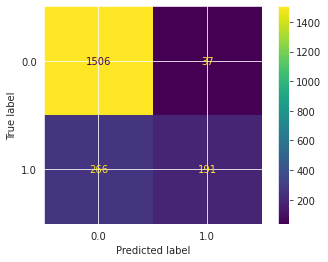

In [72]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(tuned_model, X_test, y_test, normalize = None)

Observamos que la precisión del modelo es alta, pero recordamos que los datos estan desbalanceados. Para el caso de "1" tenemos 266 fallos y 191 aciertos, con un recall de 0.42. Dato que se podria mejorar, por otro lado la coluna f1 score tiene buenos resultados, pero esto es una realidad parcial. 

# Tweets Positivos, Neutros y Negativos

In [22]:
def perfil_sentimientos(df):
    print(label)
    print("=" * 12)
    print(f"Positivos: {round(100*np.mean(df.caracteristicas_sentimiento > 0),2)}")
    print(f"Neutros  : {round(100 * np.mean(df.caracteristicas_sentimiento == 0), 2)}")
    print(f"Negativos: {round(100*np.mean(df.caracteristicas_sentimiento < 0),2)}")
    print(" ")

for label, df in datos_ejercicio.groupby("label"):
    perfil_sentimientos(df)

0
Positivos: 13.95
Neutros  : 68.34
Negativos: 17.72
 
1
Positivos: 15.08
Neutros  : 66.42
Negativos: 18.5
 


Las dos clases tienen resultados similares, aun que sabemos que tenemos muchos mas datos de la clase 0. Aún así observamos que hay más tweets negativos que positivos.